<a href="https://colab.research.google.com/github/jasserkraiem/pm/blob/main/vae_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits

In [2]:
class DigitsDataset(Dataset):
  """Digits dataset from sklearn, split into train and test."""

  def __init__(self, train=True):
    digits = load_digits()
    data = digits.images / 16.0  # normalization (original values 0-16)
    targets = digits.target

    split_idx = int(0.8 * len(data))
    if train:
      self.data = data[:split_idx]
      self.targets = targets[:split_idx]
    else:
      self.data = data[split_idx:]
      self.targets = targets[split_idx:]

    # flatten 8x8 images to 64-dim vectors
    self.data = self.data.reshape(len(self.data), -1).astype(np.float32)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return torch.from_numpy(self.data[idx]), self.targets[idx]

In [3]:
class Encoder(nn.Module):
  def __init__(self, input_dim=64, hidden_dim=32, z_dim=2):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, z_dim)
    self.fc_logvar = nn.Linear(hidden_dim, z_dim)

  def forward(self, x):
    h = F.relu(self.fc1(x))
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar

In [4]:
class Decoder(nn.Module):
  def __init__(self, input_dim=2, hidden_dim=32, output_dim=64):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_out = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    h = F.relu(self.fc1(z))
    x_hat = torch.sigmoid(self.fc_out(h))
    return x_hat

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=32, z_dim=2):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [6]:
def vae_loss(x, x_hat, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [7]:
# Hyperparameters
batch_size = 64
max_epochs = 300
# max_patience = 20
lr = 1e-3
z_dim = 2

# Data
train_loader = DataLoader(DigitsDataset(train=True), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(DigitsDataset(train=False), batch_size=batch_size)

# Model + optimizer
vae = VAE(z_dim=z_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# Training
for epoch in range(max_epochs):
    total_loss = 0
    vae.train()
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 10.6686
Epoch 2, Loss: 9.0523
Epoch 3, Loss: 7.7339
Epoch 4, Loss: 6.8409
Epoch 5, Loss: 6.2269
Epoch 6, Loss: 5.8126
Epoch 7, Loss: 5.5283
Epoch 8, Loss: 5.3113
Epoch 9, Loss: 5.1504
Epoch 10, Loss: 5.0462
Epoch 11, Loss: 4.9625
Epoch 12, Loss: 4.9093
Epoch 13, Loss: 4.8711
Epoch 14, Loss: 4.8368
Epoch 15, Loss: 4.8169
Epoch 16, Loss: 4.7812
Epoch 17, Loss: 4.7946
Epoch 18, Loss: 4.7726
Epoch 19, Loss: 4.7630
Epoch 20, Loss: 4.7511
Epoch 21, Loss: 4.7363
Epoch 22, Loss: 4.7372
Epoch 23, Loss: 4.7326
Epoch 24, Loss: 4.7234
Epoch 25, Loss: 4.7139
Epoch 26, Loss: 4.7215
Epoch 27, Loss: 4.7128
Epoch 28, Loss: 4.7007
Epoch 29, Loss: 4.6892
Epoch 30, Loss: 4.7120
Epoch 31, Loss: 4.6926
Epoch 32, Loss: 4.6805
Epoch 33, Loss: 4.6883
Epoch 34, Loss: 4.6791
Epoch 35, Loss: 4.6508
Epoch 36, Loss: 4.7089
Epoch 37, Loss: 4.6509
Epoch 38, Loss: 4.6857
Epoch 39, Loss: 4.6686
Epoch 40, Loss: 4.6656
Epoch 41, Loss: 4.6671
Epoch 42, Loss: 4.6683
Epoch 43, Loss: 4.6866
Epoch 44, Loss: 4.6

In [11]:
import matplotlib.pyplot as plt

def plot_latent_space(model, test_loader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for x, y in test_loader:
            z_mu, z_logvar = model.encoder(x)
            z_std = torch.exp(0.5 * z_logvar)
            eps = torch.randn_like(z_std)
            z = z_mu + eps * z_std
            latents.append(z_mu)  # use mean, not sampled z
            labels.append(y)

    latents = torch.cat(latents).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space of Digits')
    plt.show()

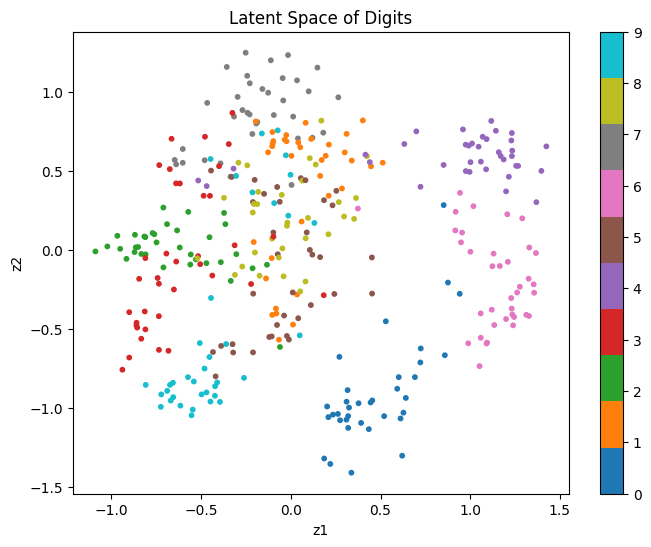

In [12]:
plot_latent_space(vae, test_loader)

In [13]:
def plot_reconstructions(model, test_loader, n=10):
    model.eval()

    # Create a new, shuffled loader for finding digits
    shuffled_loader = DataLoader(test_loader.dataset, batch_size=test_loader.batch_size, shuffle=True)

    # Find one of each digit
    digits = {}
    for x_batch, y_batch in shuffled_loader:
        for i in range(len(x_batch)):
            digit = y_batch[i].item()
            if digit not in digits:
                digits[digit] = x_batch[i]
            if len(digits) == 10:
                break
        if len(digits) == 10:
            break

    # Prepare for plotting
    x = torch.stack([digits[i] for i in range(10)])

    with torch.no_grad():
        x_recon, _, _ = model(x)

    # reshape back into 8x8 imges
    x = x.view(-1, 8, 8)
    x_recon = x_recon.view(-1, 8, 8)

    fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))

    for i in range(n):
        # Original
        axes[0, i].imshow(x[i], cmap='gray')
        # axes[0, i].set_title(f"Label: {i}")
        axes[0, i].axis('off')
        # Reconstructed
        axes[1, i].imshow(x_recon[i], cmap='gray')
        axes[1, i].axis('off')

    fig.text(0.06, 0.7, "Original", fontsize=12, va="center", rotation="vertical")
    fig.text(0.06, 0.3, "Reconstructed", fontsize=12, va="center", rotation="vertical")
    plt.suptitle("VAE Reconstructions", fontsize=14)
    plt.show()

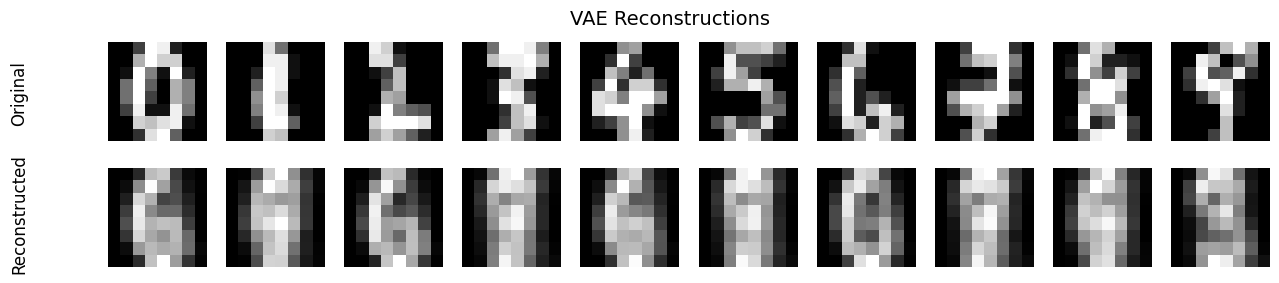

In [18]:
plot_reconstructions(vae, test_loader)

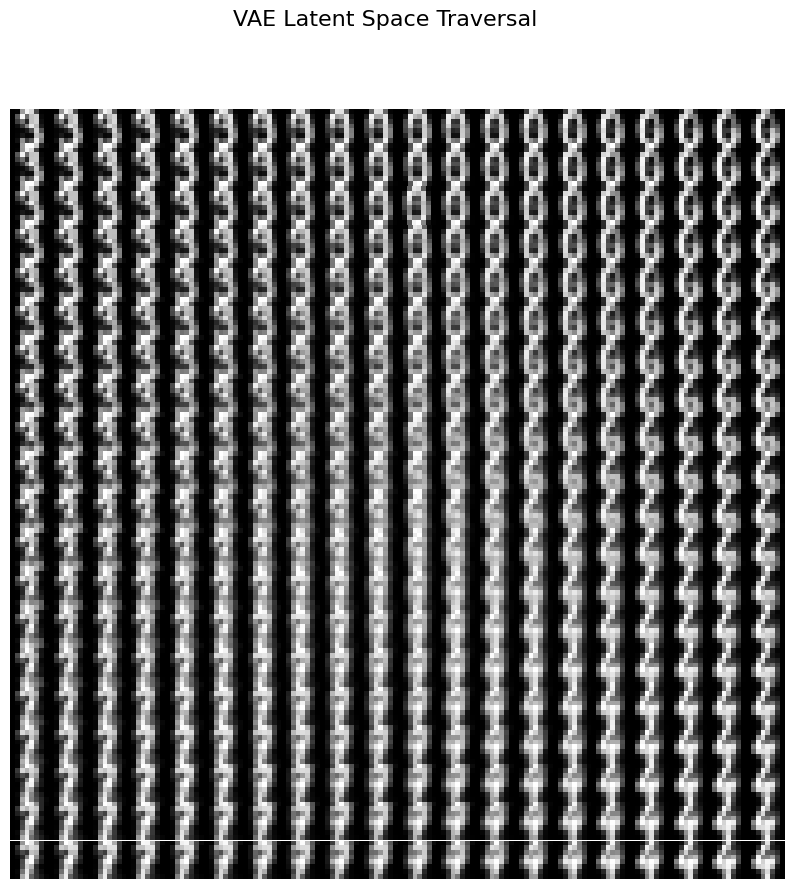

In [19]:
# Define the grid size and range
n = 20  # how many steps on each axis (15x15 grid)
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

# Create a figure
fig, axes = plt.subplots(n, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)

vae.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Create a latent vector from the grid point
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)

            # Decode it
            x_decoded = vae.decoder(z_sample).cpu().numpy()

            # Reshape the output to an image (8x8 for Digits dataset)
            img = x_decoded.reshape(8, 8)

            # Plot the digit
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')

plt.suptitle("VAE Latent Space Traversal", fontsize=16)
plt.show()